In [20]:
import matplotlib as plt
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from libs.ds_charts import get_variable_types
import libs.ds_charts as ds
import datetime

# Missing values imputation

Dropped variables ['PED_LOCATION', 'CONTRIBUTING_FACTOR_2', 'CONTRIBUTING_FACTOR_1', 'PED_ACTION']
(45669, 17)
37


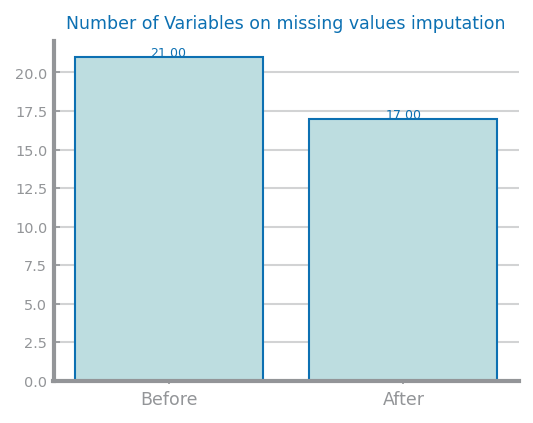

In [85]:
dataset_1 = pd.read_csv('data/NYC_collisions_tabular.csv', na_values='NaN')
new_dataset_1 = dataset_1.copy()

#FIND VARIABLES WITH MISSING VALUES
mv = {}
for var in new_dataset_1:
    nr = new_dataset_1[var].isna().sum()
    if nr > 0:
        mv[var] = nr

#DISCARD COLUMNS WITH MORE THEN 90% MISSING VALUES
threshold = new_dataset_1.shape[0] * 0.85

missings = [c for c in mv.keys() if mv[c]>threshold]
new_dataset_1.drop(columns=missings, inplace=True)
print('Dropped variables', missings)

#DISCARD RECORDS WITH MAJORITY OF MISSING VALUES
threshold = new_dataset_1.shape[1] * 0.50

new_dataset_1.dropna(thresh=threshold, inplace=True)
print(new_dataset_1.shape)

#PERSON_AGE
person_age = dataset_1['PERSON_AGE']
mean_ages = int(person_age.mean())
new_dataset_1['PERSON_AGE'].fillna(mean_ages,inplace=True)

#SAFETY_EQUIPMENT
new_dataset_1['SAFETY_EQUIPMENT'].fillna('Unknown',inplace=True)

#EJECTION
new_dataset_1['EJECTION'].fillna('Not Ejected',inplace=True)

#VEHICLE_ID
new_dataset_1['VEHICLE_ID'].fillna(0,inplace=True)

#POSITION IN VEHICLE
new_dataset_1['POSITION_IN_VEHICLE'].fillna('Unknown',inplace=True)

ds.bar_chart(xvalues=['Before','After'],yvalues=[dataset_1.shape[1],new_dataset_1.shape[1]],title="Number of Variables on missing values imputation")
savefig("lab4_images/dataset_1/missing_values_imputation")


In [56]:
print(dataset_1[dataset_1['PERSON_INJURY']=='Killed'].shape[0])
print(new_dataset_1[new_dataset_1['PERSON_INJURY']=='Killed'].shape[0])


253
253


In [57]:
file = 'nyc_collisions'
filename = 'data/nyc_collisions.csv'

week_days=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

### weekdays
new_dataset_1['CRASH_DATE'] = new_dataset_1['CRASH_DATE'].apply(lambda x: week_days[datetime.date(int(x.split('/')[0]),int(x.split('/')[1]),int(x.split('/')[0])).weekday()])    

### Dummification

In [73]:
symbolic_vars = ['CRASH_TIME','CRASH_DATE','BODILY_INJURY','SAFETY_EQUIPMENT','PERSON_SEX','EJECTION','PERSON_TYPE','COMPLAINT','EMOTIONAL_STATUS','POSITION_IN_VEHICLE','PED_ROLE']

## Transform hours to 0-22
new_dataset_1['CRASH_TIME'] = new_dataset_1['CRASH_TIME'].apply(lambda x: int(x.split(':')[0]))

def dummify(df, vars_to_dummify):
    other_vars = [c for c in df.columns if not c in vars_to_dummify]
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=bool)
    X = df[vars_to_dummify]
    encoder.fit(X)
    new_vars = encoder.get_feature_names_out(vars_to_dummify)
    trans_X = encoder.transform(X)
    dummy = pd.DataFrame(trans_X, columns=new_vars, index=X.index)
    dummy = dummy.convert_dtypes(convert_boolean=True)

    final_df = pd.concat([df[other_vars], dummy], axis=1)
    return final_df

variables = get_variable_types(new_dataset_1)
new_dataset_1 = dummify(new_dataset_1, symbolic_vars)

#remove ids, 
new_dataset_1.drop('PERSON_ID',axis=1,inplace=True)
new_dataset_1.drop('UNIQUE_ID',axis=1,inplace=True)
new_dataset_1.drop('COLLISION_ID',axis=1,inplace=True)
new_dataset_1.drop('VEHICLE_ID',axis=1,inplace=True)
new_dataset_1.drop('BODILY_INJURY_Unknown',axis=1,inplace=True)
new_dataset_1.drop('SAFETY_EQUIPMENT_None',axis=1,inplace=True)
new_dataset_1.drop('SAFETY_EQUIPMENT_Unknown',axis=1,inplace=True)
new_dataset_1.drop('COMPLAINT_Unknown',axis=1,inplace=True)
new_dataset_1.drop('EMOTIONAL_STATUS_Unknown',axis=1,inplace=True)
new_dataset_1.drop('POSITION_IN_VEHICLE_Unknown',axis=1,inplace=True)



new_dataset_1.to_csv(f'data/{file}_dummified.csv', index=False)
nr = new_dataset_1.isna().sum()

### Outliers imputation

In [59]:
# AGE
new_dataset_1 = new_dataset_1[(new_dataset_1.PERSON_AGE < 110) & (new_dataset_1.PERSON_AGE > 0)]


## Scalling

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import subplots, show

'''
 we need to apply the transfomation and rejoin the data together in order
 to have a unique dataframe. They can only be applied to numerical data, 
 without any missing value. In order to do that, we are splitting our dataframe into three 
 dataframes, one for each data type: above, discarding date variables, since the majority of 
 techniques are not able to deal with them.
'''

variable_types = get_variable_types(new_dataset_1)
numeric_vars = ['PERSON_AGE']
symbolic_vars2 = []
boolean_vars = variable_types['Binary']

df_nr = new_dataset_1[numeric_vars]
df_sb = new_dataset_1[symbolic_vars2]
df_bool = new_dataset_1[boolean_vars]

print(numeric_vars)
print(symbolic_vars2)
#print(boolean_vars)

['PERSON_AGE']
[]


          PERSON_AGE CRASH_TIME_0 CRASH_TIME_1 CRASH_TIME_2 CRASH_TIME_3  \
count   45592.000000        45592        45592        45592        45592   
unique           NaN            2            2            2            2   
top              NaN        False        False        False        False   
freq             NaN        43374        44431        44702        44843   
mean        0.361721          NaN          NaN          NaN          NaN   
std         0.166223          NaN          NaN          NaN          NaN   
min         0.000000          NaN          NaN          NaN          NaN   
25%         0.242424          NaN          NaN          NaN          NaN   
50%         0.333333          NaN          NaN          NaN          NaN   
75%         0.474747          NaN          NaN          NaN          NaN   
max         1.000000          NaN          NaN          NaN          NaN   

       CRASH_TIME_4 CRASH_TIME_5 CRASH_TIME_6 CRASH_TIME_7 CRASH_TIME_8  ...  \
count  

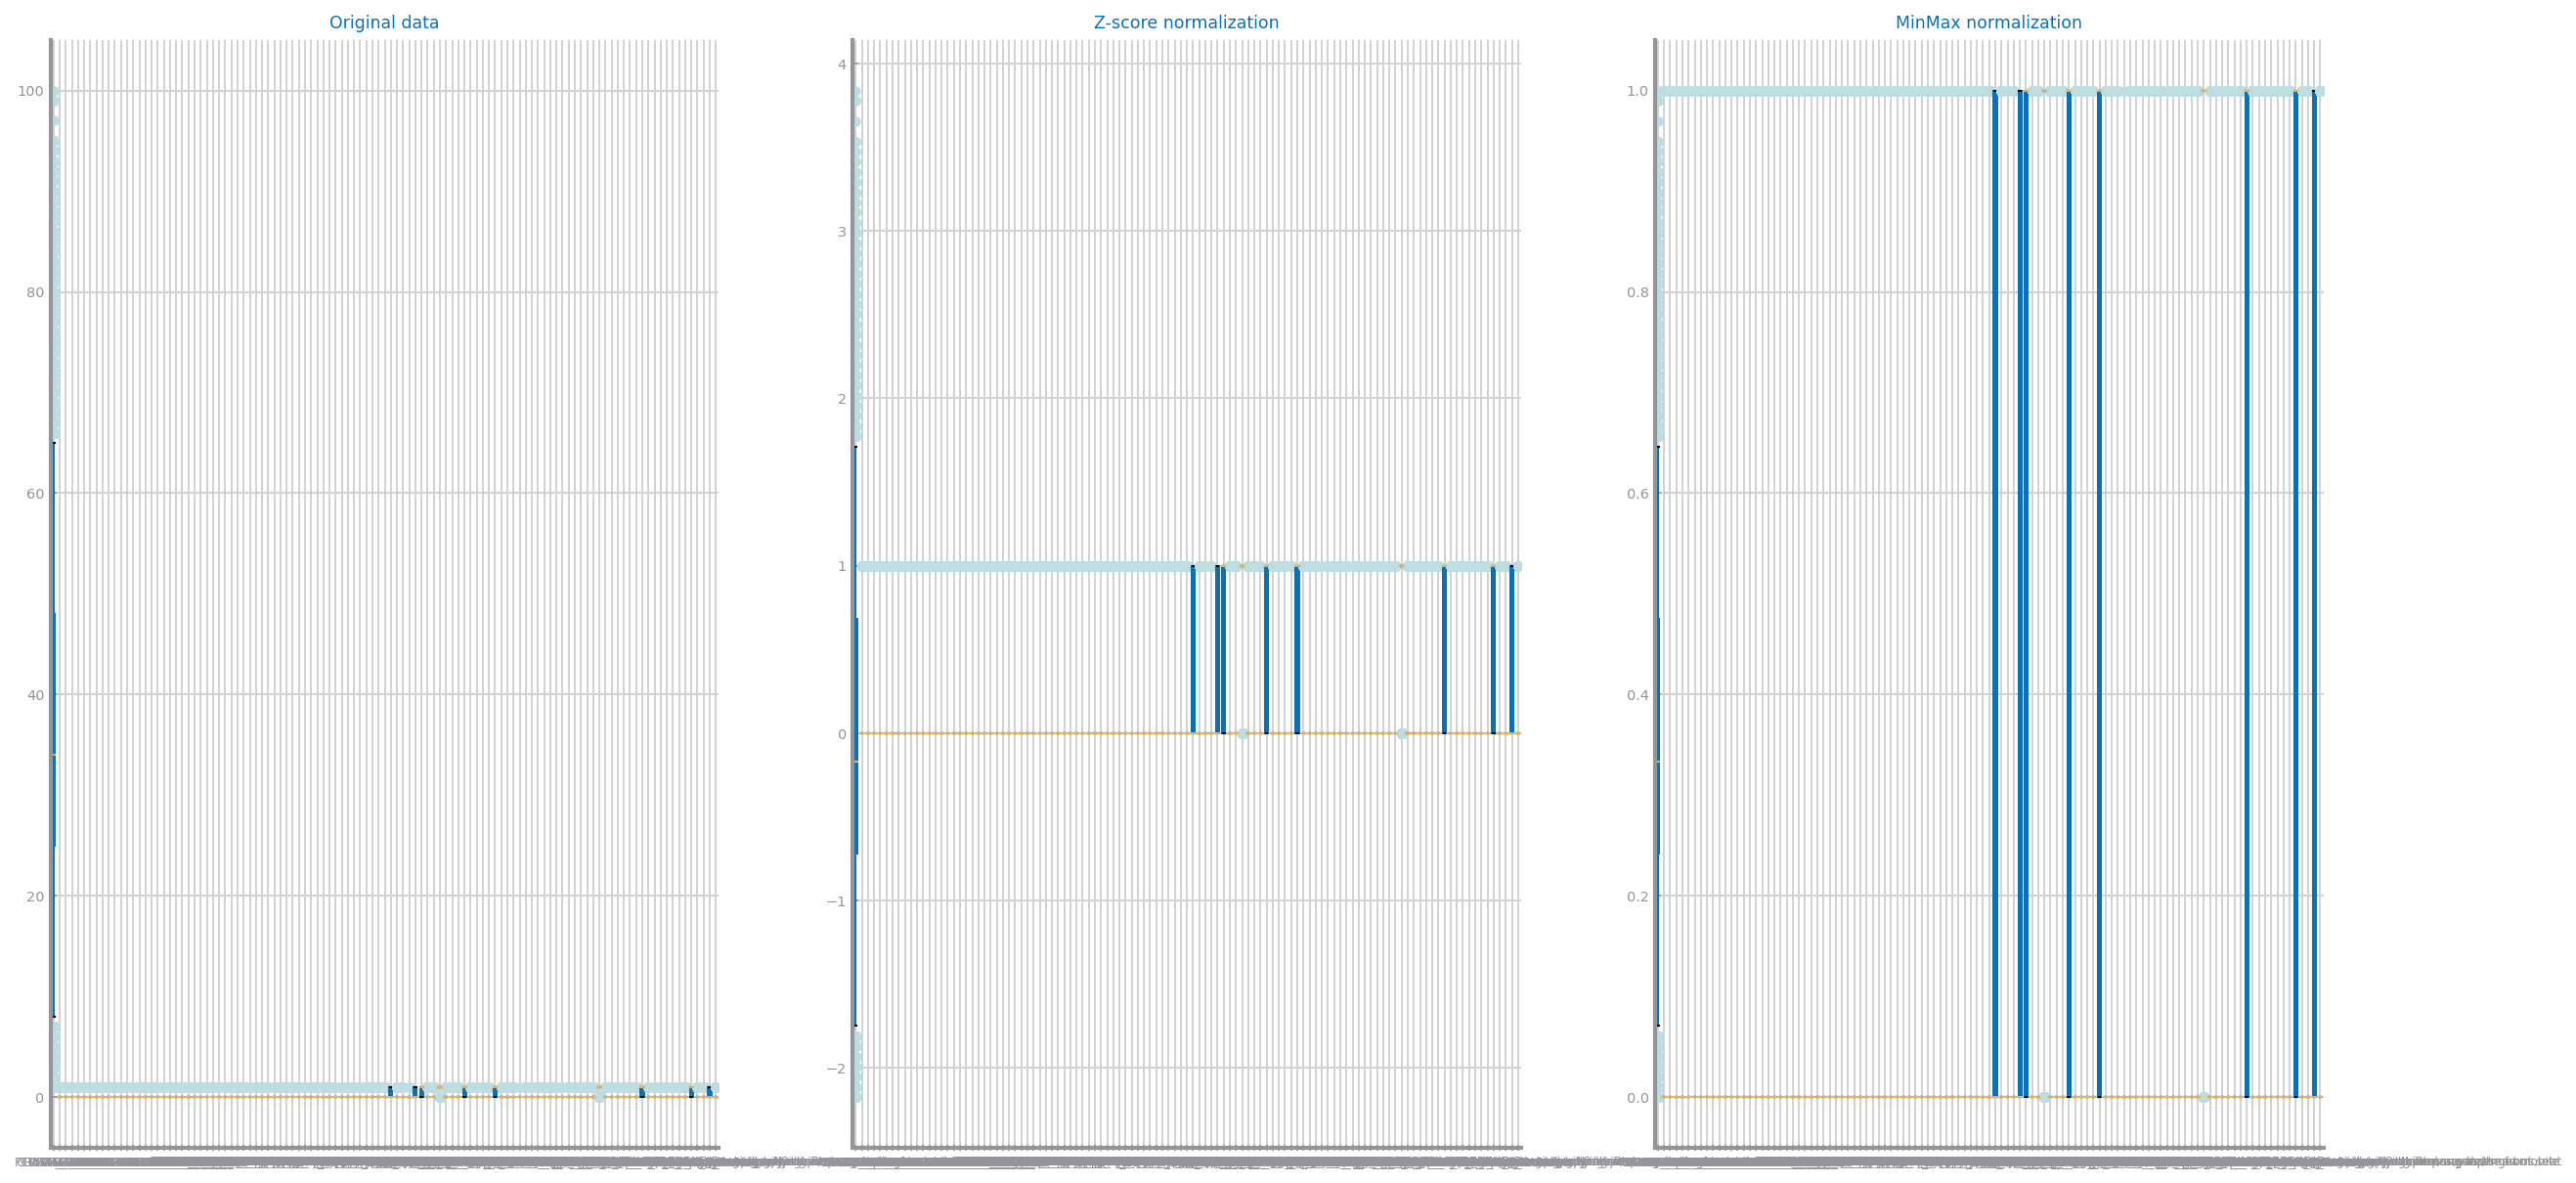

In [61]:
transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
tmp = pd.DataFrame(transf.transform(df_nr), index=new_dataset_1.index, columns= numeric_vars)
norm_data_zscore = pd.concat([tmp, df_sb,  df_bool], axis=1)
norm_data_zscore.to_csv(f'data/{file}_scaled_zscore.csv', index=False)

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = pd.DataFrame(transf.transform(df_nr), index=new_dataset_1.index, columns= numeric_vars)
norm_data_minmax = pd.concat([tmp, df_sb,  df_bool], axis=1)
norm_data_minmax.to_csv(f'data/{file}_scaled_minmax.csv', index=False)
print(norm_data_minmax.describe())
df = new_dataset_1
# Now we can se the result of the transformed data with a single boxplot, again.

fig, axs = subplots(1, 3, figsize=(20,10),squeeze=False)
axs[0, 0].set_title('Original data')
df.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title('MinMax normalization')
norm_data_minmax.boxplot(ax=axs[0, 2])
show()

### TRAIN AND TEST ZSCORE

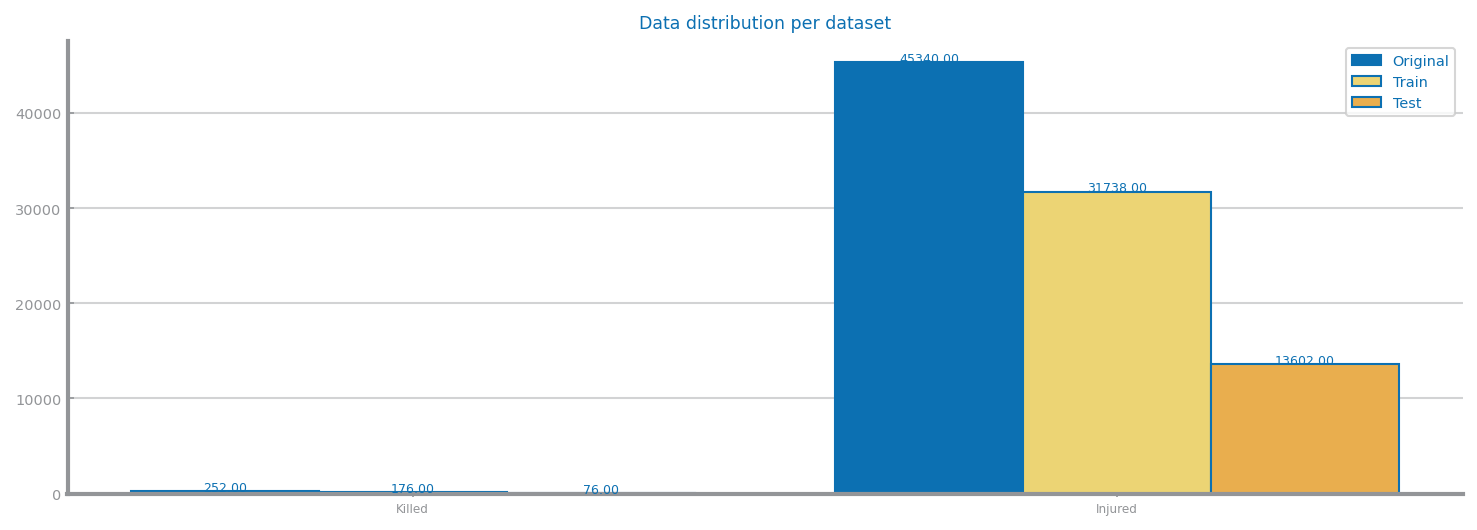

In [62]:
import numpy as np
from pandas import read_csv, concat, unique, DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

file_tag = 'nyc_collisions_scaled_zscore'
data: DataFrame = read_csv('data/nyc_collisions_scaled_zscore.csv')
target = 'PERSON_INJURY'
positive = 'Killed'
negative = 'Injured'
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}

y: np.ndarray = data.pop(target).values
X: np.ndarray = data.values
labels: np.ndarray = unique(y)
labels.sort()

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

train = concat([DataFrame(trnX, columns=data.columns), DataFrame(trnY,columns=[target])], axis=1)
train.to_csv(f'data/{file_tag}_train.csv', index=False)

test = concat([DataFrame(tstX, columns=data.columns), DataFrame(tstY,columns=[target])], axis=1)
test.to_csv(f'data/{file_tag}_test.csv', index=False)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
plt.show()

### TRAIN AND TEST MINMAX

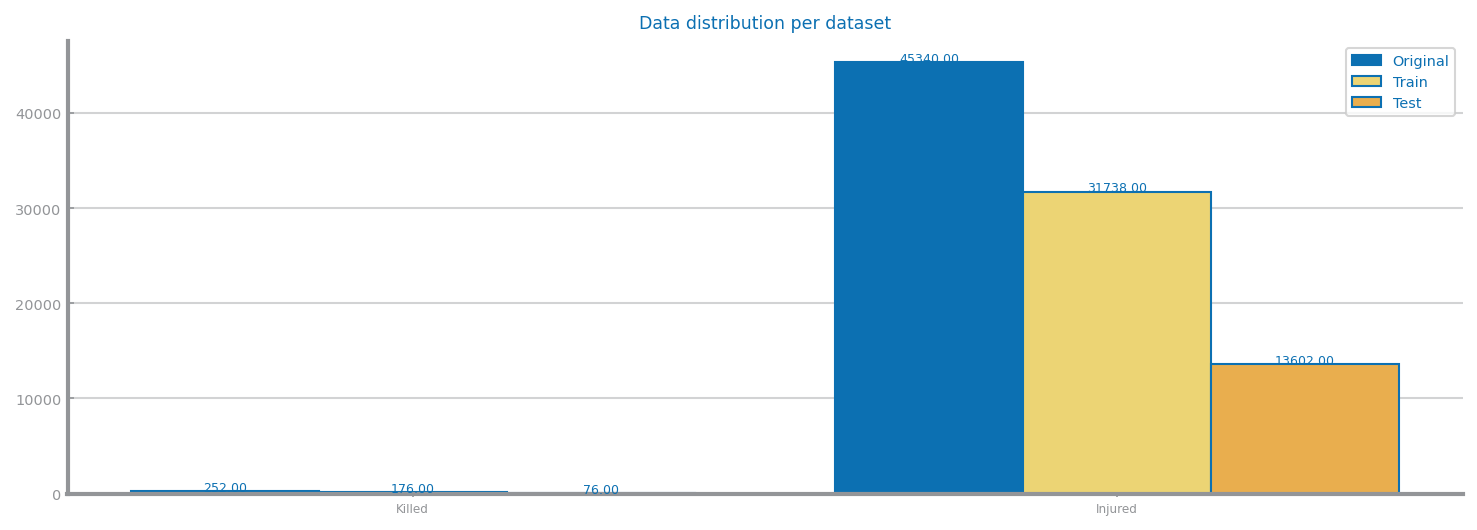

In [63]:
import numpy as np
from pandas import read_csv, concat, unique, DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

file_tag = 'nyc_collisions_scaled_minmax'
data: DataFrame = read_csv('data/nyc_collisions_scaled_minmax.csv')
target = 'PERSON_INJURY'
positive = 'Killed'
negative = 'Injured'
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}

y: np.ndarray = data.pop(target).values
X: np.ndarray = data.values
labels: np.ndarray = unique(y)
labels.sort()

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

train = concat([DataFrame(trnX, columns=data.columns), DataFrame(trnY,columns=[target])], axis=1)
train.to_csv(f'data/{file_tag}_train.csv', index=False)

test = concat([DataFrame(tstX, columns=data.columns), DataFrame(tstY,columns=[target])], axis=1)
test.to_csv(f'data/{file_tag}_test.csv', index=False)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
plt.show()

### KNN STUDY ZSCORE

manhattan
euclidean
chebyshev


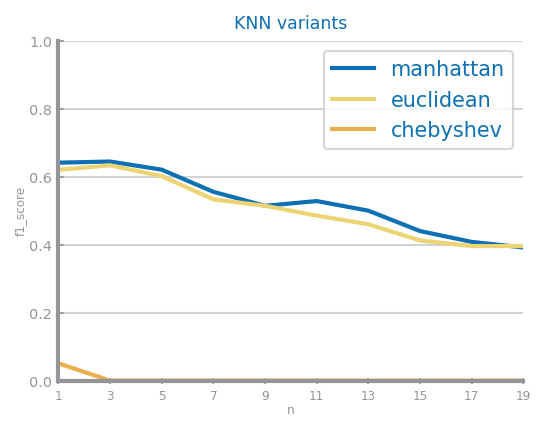

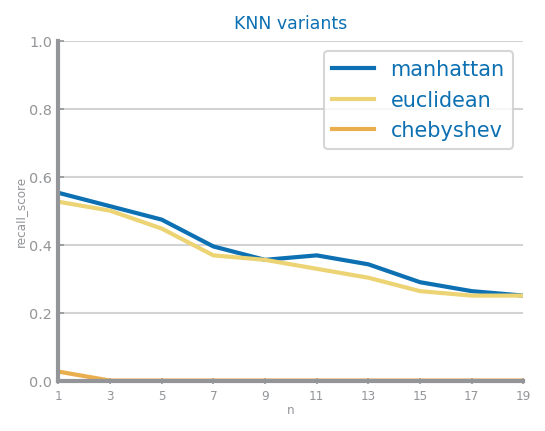

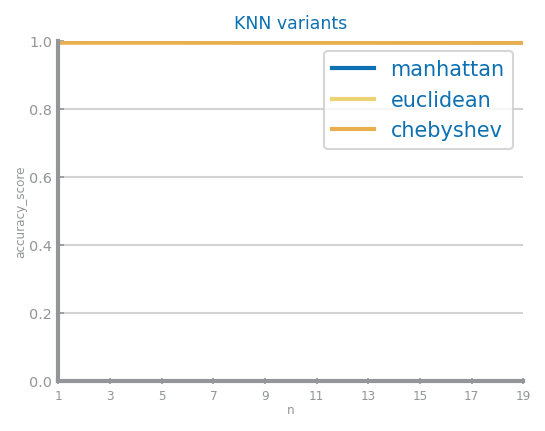

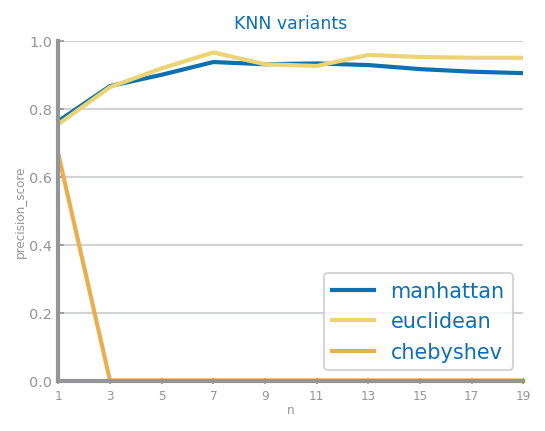

Best results with 3 neighbors and manhattan


In [64]:
from numpy import ndarray
from pandas import DataFrame, read_csv, unique
from matplotlib.pyplot import figure, savefig, show
from sklearn.neighbors import KNeighborsClassifier
from libs.ds_charts import plot_evaluation_results, multiple_line_chart
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

target = 'PERSON_INJURY'
filename = 'nyc_collisions_scaled_zscore'
train: DataFrame = read_csv(f'data/{filename}_train.csv')
#train.drop(['CRASH_DATE','CRASH_TIME'],axis=1,inplace=True)
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv(f'data/{filename}_test.csv')
#test.drop(['CRASH_DATE','CRASH_TIME'],axis=1,inplace=True)
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
f1 = {}
recall = {}
accuracy = {}
precision = {}

best_f1 = (0, '')
last_best_f1 = 0

best_recall = (0, '')
last_best_recall = 0

best_accuracy = (0, '')
last_best_accuracy = 0

best_precision = (0, '')
last_best_precision = 0


for d in dist:
    print(d)
    yvalues_f1 = []
    yvalues_recall = []
    yvalues_accuracy = []
    yvalues_precision = []

    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        
        yvalues_f1.append(f1_score(tstY, prdY, pos_label='Killed')) ## Using F1 SCORE
        if yvalues_f1[-1] > last_best_f1:
            best_f1 = (n, d)
            last_best_f1 = yvalues_f1[-1]
            
        yvalues_recall.append(recall_score(tstY, prdY, pos_label='Killed')) ## Using RECALL SCORE
        if yvalues_recall[-1] > last_best_recall:
            best_recall = (n, d)
            last_best_recall = yvalues_recall[-1]
            
        yvalues_accuracy.append(accuracy_score(tstY, prdY)) ## Using ACCURACY SCORE
        if yvalues_accuracy[-1] > last_best_accuracy:
            best_accuracy = (n, d)
            last_best_accuracy = yvalues_accuracy[-1]
            
        yvalues_precision.append(precision_score(tstY, prdY, pos_label='Killed')) ## Using ACCURACY SCORE
        if yvalues_precision[-1] > last_best_precision:
            best_precision = (n, d)
            last_best_precision = yvalues_precision[-1]
            
    f1[d] = yvalues_f1
    recall[d] = yvalues_recall
    accuracy[d] = yvalues_accuracy
    precision[d] = yvalues_precision

figure()
multiple_line_chart(nvalues, f1, title='KNN variants', xlabel='n', ylabel='f1_score', percentage=True)
savefig('lab4_images/dataset_1/nyc_collisions_zscore_knn_f1_study.png')
show()

figure()
multiple_line_chart(nvalues, recall, title='KNN variants', xlabel='n', ylabel='recall_score', percentage=True)
savefig('lab4_images/dataset_1/nyc_collisions_zscore_knn_recall_study.png')
show()

figure()
multiple_line_chart(nvalues, accuracy, title='KNN variants', xlabel='n', ylabel='accuracy_score', percentage=True)
savefig('lab4_images/dataset_1/nyc_collisions_zscore_knn_accuracy_study.png')
show()

figure()
multiple_line_chart(nvalues, precision, title='KNN variants', xlabel='n', ylabel='precision_score', percentage=True)
savefig('lab4_images/dataset_1/nyc_collisions_zscore_knn_precision_study.png')
show()

print('Best results with %d neighbors and %s'%(best_f1[0], best_f1[1]))

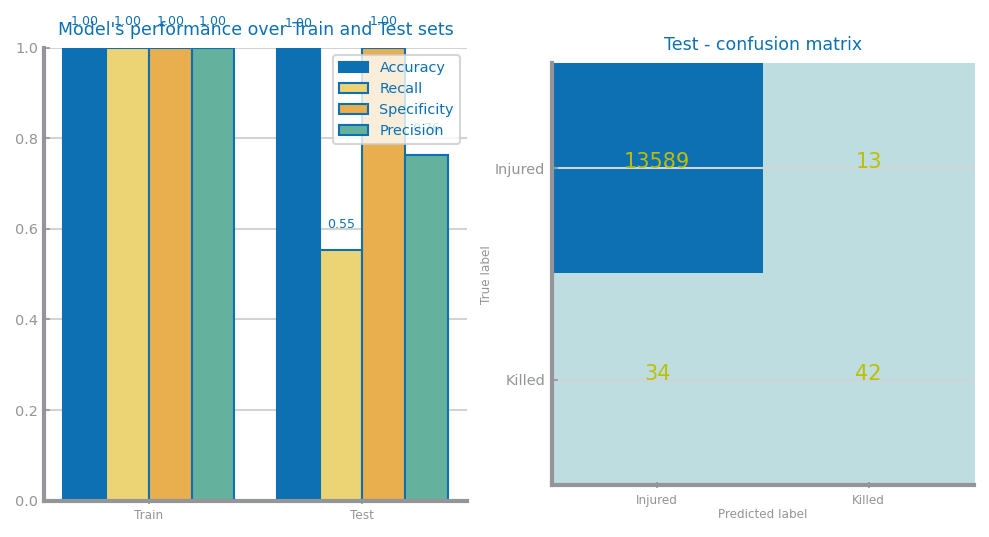

In [65]:
clf = knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
savefig('images/nyc_collisions_knn_best_ds1.png')
show()

### KNN MINMAX

manhattan
euclidean
chebyshev


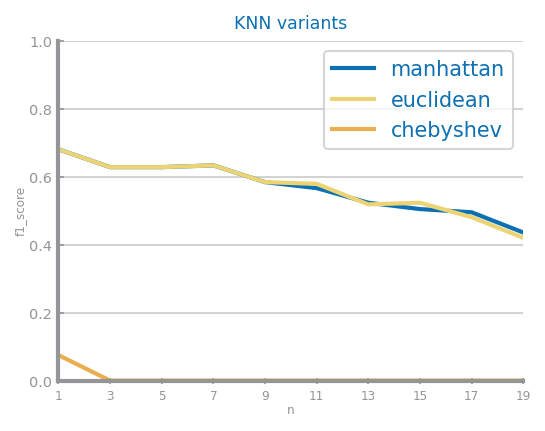

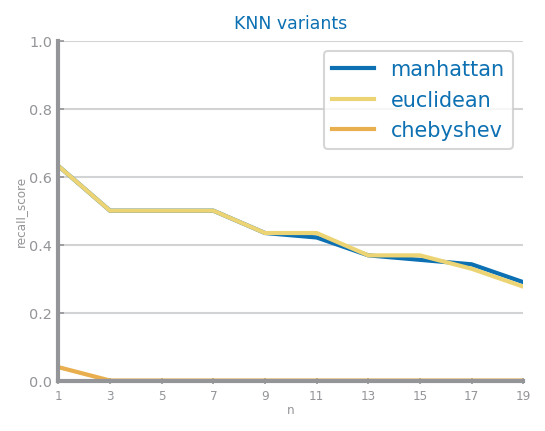

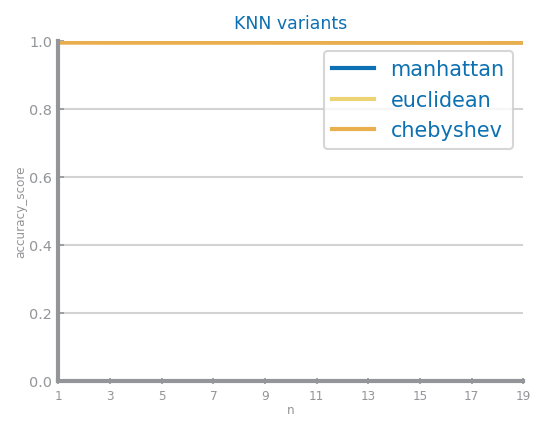

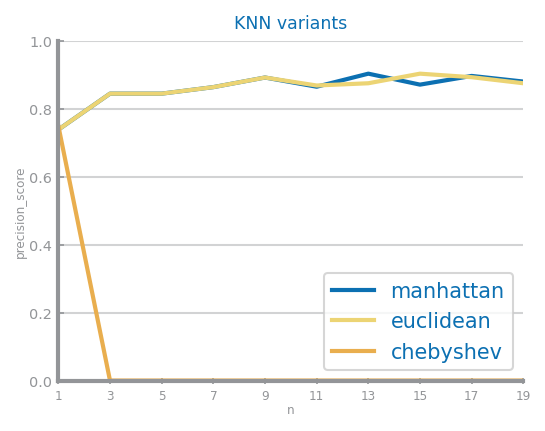

Best results with 1 neighbors and manhattan


In [74]:
from numpy import ndarray
from pandas import DataFrame, read_csv, unique
from matplotlib.pyplot import figure, savefig, show
from sklearn.neighbors import KNeighborsClassifier
from libs.ds_charts import plot_evaluation_results, multiple_line_chart
from sklearn.metrics import accuracy_score, recall_score

target = 'PERSON_INJURY'
filename = 'nyc_collisions_scaled_minmax'
train: DataFrame = read_csv(f'data/{filename}_train.csv')
#train.drop(['CRASH_DATE','CRASH_TIME'],axis=1,inplace=True)
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv(f'data/{filename}_test.csv')
#test.drop(['CRASH_DATE','CRASH_TIME'],axis=1,inplace=True)
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
f1 = {}
recall = {}
accuracy = {}
precision = {}

best_f1 = (0, '')
last_best_f1 = 0

best_recall = (0, '')
last_best_recall = 0

best_accuracy = (0, '')
last_best_accuracy = 0

best_precision = (0, '')
last_best_precision = 0


for d in dist:
    print(d)
    yvalues_f1 = []
    yvalues_recall = []
    yvalues_accuracy = []
    yvalues_precision = []

    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        
        yvalues_f1.append(f1_score(tstY, prdY, pos_label='Killed')) ## Using F1 SCORE
        if yvalues_f1[-1] > last_best_f1:
            best_f1 = (n, d)
            last_best_f1 = yvalues_f1[-1]
            
        yvalues_recall.append(recall_score(tstY, prdY, pos_label='Killed')) ## Using RECALL SCORE
        if yvalues_recall[-1] > last_best_recall:
            best_recall = (n, d)
            last_best_recall = yvalues_recall[-1]
            
        yvalues_accuracy.append(accuracy_score(tstY, prdY)) ## Using ACCURACY SCORE
        if yvalues_accuracy[-1] > last_best_accuracy:
            best_accuracy = (n, d)
            last_best_accuracy = yvalues_accuracy[-1]
            
        yvalues_precision.append(precision_score(tstY, prdY, pos_label='Killed')) ## Using ACCURACY SCORE
        if yvalues_precision[-1] > last_best_precision:
            best_precision = (n, d)
            last_best_precision = yvalues_precision[-1]
            
    f1[d] = yvalues_f1
    recall[d] = yvalues_recall
    accuracy[d] = yvalues_accuracy
    precision[d] = yvalues_precision

figure()
multiple_line_chart(nvalues, f1, title='KNN variants', xlabel='n', ylabel='f1_score', percentage=True)
savefig('lab4_images/dataset_1/nyc_collisions_minmax_knn_f1_study.png')
show()

figure()
multiple_line_chart(nvalues, recall, title='KNN variants', xlabel='n', ylabel='recall_score', percentage=True)
savefig('lab4_images/dataset_1/nyc_collisions_minmax_knn_recall_study.png')
show()

figure()
multiple_line_chart(nvalues, accuracy, title='KNN variants', xlabel='n', ylabel='accuracy_score', percentage=True)
savefig('lab4_images/dataset_1/nyc_collisions_minmax_knn_accuracy_study.png')
show()

figure()
multiple_line_chart(nvalues, precision, title='KNN variants', xlabel='n', ylabel='precision_score', percentage=True)
savefig('lab4_images/dataset_1/nyc_collisions_minmax_knn_precision_study.png')
show()

print('Best results with %d neighbors and %s'%(best_f1[0], best_f1[1]))

In [ ]:
clf = knn = KNeighborsClassifier(n_neighbors=best_f1[0], metric=best_f1[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
savefig('lab4_images/dataset_1/nyc_collisions_minmax_knn_best_ds1.png')
show()